In [2]:
#from util import *
#from DSRN import *
import torch
import sys
import os
cwd = os.getcwd()
print(cwd)
outputs = torch.load(os.path.join(os.getcwd(), 'model',"output.pth"))

/home/abdikhab/comp/DSRN


In [8]:
outputs[100,:,:].sum(0)

tensor([12., 12., 12., 12., 12.,  0., 12., 12., 12., 12.], device='cuda:0',
       grad_fn=<SumBackward1>)

Data Loading and Preperation

In [2]:
csvpath = R"Vib_data.csv"
df, datalen= loadcsv(csvpath)
dataset = FaultData()
dataset.prepare(df, datalen, ignore = [10,11,12])
train, test = dataset.split(128,0.85)

Loading file: Vib_data.csv
Data prepared with max and min of: tensor(11.6740) tensor(-10.0919)
Train size: 2414 Test size: 426


tensor(0)

In [4]:
# Create the model
imsize = 49
Loadmodel = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DSRN(nb_blocks=64, in_ch=1, out_ch=16, imsize= imsize, device=device).to(device)
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1, betas=(0.9, 0.999))
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1) # decay LR by a factor of 0.1 every 10 epochs
if Loadmodel == True:
    model.load_state_dict(torch.load('model.pth'))
    print('model loaded')
# check if cuda is available
if torch.cuda.is_available():
    model = model.to(device)
    criterion = criterion.to(device)
    print("cuda is available")



cuda is available


In [ ]:
# Create the model
epochs = 150
loss_ep = []
prev_loss = 10000
# Train the model
for epoch in range(epochs):
    train_loss = 0.0
    for inputs, labels in train:
        model.train()
        # forward + backward + optimize
        inputs = dataset.str2image(inputs,imsize, imsize)
        inputs = inputs.unsqueeze(1).to(device) #add channel dim
        print(inputs.shape)
        outputs = model(inputs)
        loss = criterion(outputs.sum(1), labels.to(device))
        # zero the parameter gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # print statistics
        train_loss += loss.item()
    loss_ep.append(train_loss / len(train))
    lr_scheduler.step() #decay learning rate
    print('epoch: %d loss: %.3f' % (epoch + 1, train_loss / len(train)))
    if prev_loss > train_loss:
        torch.save(model.state_dict(), 'model.pth')
        print('checkpoint saved')
        prev_loss = train_loss

In [ ]:
import matplotlib.pyplot as plt
def str2image(x, H, W):
    # zero padding if the lengh is not enough
    if x.size(1) < H*W:
        x = torch.cat((x, torch.zeros(x.size(0), H*W-x.size(1))), dim=1)
        
    if x.size(1) >= H*W:
        x = x[:,:H*W]
    x = x.reshape(x.size(0), H, W)
    x = 255*(x +10)//(11 + 10)

    return x
d =0
for data , label in train:
    data = str2image(data, 48, 48)
    for i in range(len(label)):
        if label[i] == 5:
            plt.imshow(data[i], cmap='gray')
            plt.show()
            d = 1
            break

plt.show()

In [3]:
# test the model
import torch
import torch.nn as nn
import torch.optim as optim
import snntorch as snn
#load the model from the checkpoint
imsize = 64
model = DSRN(nb_blocks=64, in_ch=1, out_ch=8, imsize= imsize, device=device).to(device)
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.05, betas=(0.9, 0.999))
model.load_state_dict(torch.load('model.pth'))

test_losses = []
pred_results = torch.empty(0, device = device)
true_labels = torch.empty(0, device = device)
with torch.no_grad():
    model.eval()
    for x, y in test:
        x = dataset.str2image(x, imsize, imsize)
        x = x.unsqueeze(1).to(device)
        outputs = model(x)
        _, predicted = torch.max(outputs.sum(1), 1)
        pred_results= torch.cat((pred_results,predicted), dim = 0)
        true_labels = torch.cat((true_labels, y.to(device)), dim = 0)
        tests_loss = criterion(outputs.sum(1), y.to(device))
        test_losses.append(tests_loss.item())



NameError: name 'model' is not defined

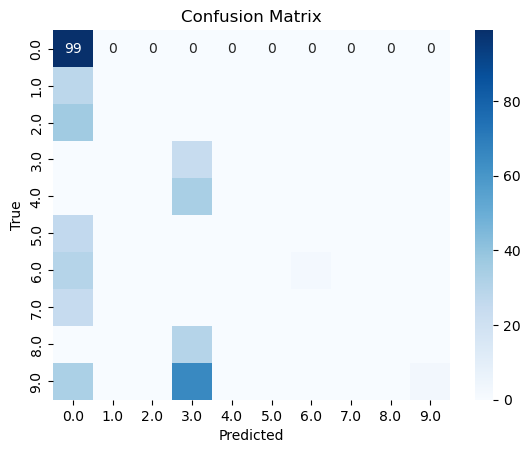

Accuracy:  29.42528735632184 %


In [56]:
# confusion matrix
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

true_labels = true_labels.cpu()
pred_results = pred_results.cpu()
cm = confusion_matrix(true_labels, pred_results)
# Plot the confusion matrix
classes = np.unique(true_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
print('Accuracy: ', accuracy_score(true_labels, pred_results)*100, '%')

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import snntorch as snn

class DSRN(nn.Module):
    def __init__(self, nb_blocks, in_ch, out_ch,imsize,device, strides=1, kernelsize=3, padding=1):
        super(DSRN, self).__init__()
        self.nb_blocks = nb_blocks
        self.out_ch = out_ch
        self.kernel_size = kernelsize
        self.padding = padding
        self.stride = strides
        self.in_ch = in_ch
        self.imsize = imsize
        self.betta1 = 0.25 # torch.rand(self.out_ch, device= device)
        self.betta2 = 0.25 #torch.rand(self.out_ch, device= device)
        self.device = device
        self.out_s = (self.imsize - self.kernel_size + 2*self.padding)//self.stride + 1
        self.class_size = 10
        self.Conv2d1 = nn.Conv2d(self.in_ch, self.out_ch, self.kernel_size, stride= self.stride, padding=1)
        self.SRBU1 = SRU(self.nb_blocks, self.out_ch, self.out_ch, self.imsize, self.device)
        self.maxpool1 = nn.MaxPool2d(2)
        self.maxpool1_s = (self.imsize - 2)//2 + 1

        self.SRBU2 = SRU(self.nb_blocks, self.out_ch, self.out_ch, self.maxpool1_s, self.device)
        self.maxpool2 = nn.MaxPool2d(2)
        self.maxpool2_s = (self.imsize//2 - 2)//2 + 1

        self.SRBU3 = SRU(self.nb_blocks, self.out_ch, self.out_ch, self.maxpool2_s, self.device)
        self.maxpool3 = nn.MaxPool2d(2)
        self.maxpool3_s = (self.imsize//4 - 2)//2 + 1
        self.flatten = nn.Flatten(1)
        self.BN1 = nn.BatchNorm1d(self.maxpool3_s**2*self.out_ch)
        self.IF1 = snn.Leaky(beta = self.betta1, learn_threshold= True, learn_beta=False)    #LIF(self.out_ch)
        self.FC1 = nn.Linear(self.maxpool3_s**2*self.out_ch, self.maxpool3_s*self.out_ch)
        self.IF2 = snn.Leaky(beta= self.betta2, learn_threshold= True)      #LIF(self.out_ch)
        #self.FC2 = nn.Linear(self.out_s*self.nb_blocks**2, self.class_size)
        #self.softmax = nn.Softmax(dim =1)
    def forward(self, x):

        out = torch.empty(x.shape[0], 0, device= self.device)
        mem1= self.IF1.init_leaky()
        mem2 = self.IF2.init_leaky()
        for step in range(self.nb_blocks):
            next_l = self.Conv2d1(x)
            next_l = self.SRBU1(next_l)
            next_l = self.maxpool1(next_l)
            next_l = self.SRBU2(next_l)
            next_l = self.maxpool2(next_l)
            next_l = self.SRBU3(next_l)
            next_l = self.maxpool3(next_l)
            
            next_l = self.flatten(next_l)
            next_l = self.BN1(next_l)
            next_l, mem1 = self.IF1(next_l, mem1)
            next_l = self.FC1(next_l)
            next_l, mem2 = self.IF2(next_l, mem2)
            out = torch.cat((out, next_l), 1)
        return out
    #convert the residual shrinkage block to pytorch
class SoftThresholdLayer(nn.Module):
    def __init__(self, threshold_init=1.0):
        super(SoftThresholdLayer, self).__init__()
        self.threshold = nn.Parameter(torch.tensor(threshold_init))
    def forward(self, x, thres):
        return torch.sign(x) * torch.relu(torch.abs(x) - thres)

class SRU(nn.Module):
    def __init__(self, nb_blocks,in_ch, out_ch, imsize, device, kernel_size = 3, stride=1, padding=1):
        super(SRU, self).__init__()
        self.nb_blocks = nb_blocks
        self.out_ch = out_ch
        self.kernel_size = kernel_size
        self.stride = stride
        self.sigma = 4
        self.in_ch = in_ch
        self.padding = padding
        self.betta1 = 0.25 #torch.rand(self.out_ch)
        self.betta2 = 0.25 #torch.rand(self.out_ch)
        self.th = 0.1
        self.imsize = imsize
        self.device = device

        self.conv1out_s = self.convcalc(self.imsize, self.kernel_size,self.padding , self.stride)
        self.conv2out_s = self.convcalc(self.conv1out_s, self.kernel_size,self.padding , self.stride)
        self.avgpool_s = self.convcalc(self.conv2out_s, self.imsize//4, 0, self.imsize//4)
        
        self.BN1 = nn.BatchNorm2d(self.out_ch)
        self.IF1 = snn.Leaky(beta = self.betta1, learn_threshold= False)    #LIF(self.out_ch)
        self.Conv2d1 = nn.Conv2d(self.in_ch, self.out_ch, self.kernel_size, stride= self.stride, padding=1) # it should output a flatten tensor
        
        self.BN2 = nn.BatchNorm2d(self.out_ch)
        self.IF2 = snn.Leaky(beta= self.betta2, learn_threshold= False)      #LIF(self.out_ch)
        self.Conv2d2 = nn.Conv2d(self.out_ch, self.out_ch, self.kernel_size, stride=self.stride, padding=1)
        
        
        self.AvgPool2d = nn.AvgPool2d(kernel_size= (self.imsize, self.imsize))
        #self.flatten = nn.Flatten(2)
        self.FC1 = nn.Linear(1, 10)
        self.FC2 = nn.Linear(10, 1)
        self.sigmoid = nn.Sigmoid()
        self.soft_threshold = SoftThresholdLayer(threshold_init=1.0)

    def forward(self, x):
        mem1= self.IF1.init_leaky()
        mem2 = self.IF2.init_leaky()
        #mem_out = []
        residual = x
        #for step in range(self.nb_blocks):
        
        residual = self.BN1(residual)
        residual, _ = self.IF1(residual, mem1)
        residual = self.Conv2d1(residual)

        
        residual = self.BN2(residual) # batch normalization
        residual, _ = self.IF2(residual, mem2) # leaky integrate and fire
        residual = self.Conv2d2(residual) # convolution

        #  Squeeze and Excitation layer
        scales = self.AvgPool2d(residual)
        #scales = self.flatten(scales)
        feedback = self.FC1(scales)
        feedback = self.sigmoid(self.FC2(feedback))
        #multiply scales with feedback
        thres = torch.multiply(scales, feedback)
        #soft thresholding
        out = self.soft_threshold(residual, thres)

        out = torch.add(out , x) # sum layer
        return out
    
    def convcalc(self, inpt, krnl,padding, stride):
        return (inpt - krnl + 2*padding)//stride + 1
    
